<a href="https://colab.research.google.com/github/yehaa2004/Naan-mudhalvan-projects/blob/main/USE_CASE_2_HANDWRITING_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'handwritten-characters:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F53376%2F101598%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240428%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240428T044206Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D11a3e8ea9c823cf483e7229178295ce569188f3479303579961089252bf0bc8476842f3bdae05c0a5695c86511ca4047c1d426dc03d5e099449abaddccfe2d9e76d8e97f90fbe712c874a044e47e4e49e862d100c7ed0a066bfd858b215021a00f6eebd8fae0192a31724ee0ea436e7e7090a8cf33fe30cbfe31dda5f69364c37b3a837fccec0fb8129aa67559d7f730abef8d4c5b0f29aa948fbc30fdb55f4e48982ce865387fb22b03eb03459c0bc018f88d198e77f2ff37e69e4844ebbf858def8c8fb8a3bd639d06bd81d94fcee9fd640496388e999e547c00d01e95e85b4e3afd7ea4725c3f60f5644bef27eca0e1e978a2b11f1f79e47b2e7144a5fcf1,handwriting-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F818027%2F1400106%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240428%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240428T044206Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D968daf97119c7ab713090f630bde44c77d473d24f133cf20f0d635fc9c3f1fc7c2a104416f02e629e4c5da244cd1fde8735b8c38380a4c9ba16f22bc39ec1027834d12e89d6424936222dbf1e6d82b51fce4b0504be213473352532c958beac6707468936eeec10c9b6d32a9a04b14457c1790052f298e32721218a806fc521dc02bbfe56b15be5583c86fa5f2793f0dee9a24c7e8651a50844310a1039d73b0f7a8ab3827223cc83be581640b80eb95a43f5c40a0ced71fe0cc5b6ed19e2d86004587c51f24b0542cfb39b0ca73a4acf6b4dcca3bcf8795d35ee56ca02a6443dd25d289d492bfebde4416604f37ba2a6e7a72066fa206165f2eaebfffea404d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1740501298 bytes downloaded
Downloaded and uncompressed: handwritten-characters
[==================================================] 1353071625 bytes downloaded
Downloaded and uncompressed: handwriting-recognition
Data source import complete.


In [2]:
from tensorflow.keras.models import load_model

# *Offline Handwritten Text Recognition*

### The purpose of this notebook is to give a brief idea and a basic approach for offline handwritten text recognition by using segmentation and classification.

## What is Offline Handwritten Text Recognition?
Offline handwriting recognition involves the automatic conversion of text in an image into letter codes that are usable within computer and text-processing applications. In simple terms, it is the text extraction from your handwritten notebooks/pages. Why called offline? The point being that there is an online text recognition system, which is referred for text that is digitally generated by using tools like stylus, apple pencil, etc.

## Approach

* **Step1** :  Build a digit(0-9) + A-Z characters classifier using a CNN architecture.
* **Step2** :  Apply character segmentation for the handwritten word image.
* **Step3** :  Classify each segmented letter and then get the final word in the image.

In [4]:
!pip install imutils

In [5]:
!pip install keras

In [6]:
from keras.utils import to_categorical

In [10]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [11]:
dir = "../input/handwritten-characters/Train/"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [12]:
len(train_data)

140000

In [13]:
val_dir = "../input/handwritten-characters/Validation/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

In [14]:
len(val_data)

15209

In [15]:
random.shuffle(train_data)
random.shuffle(val_data)

In [16]:
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [17]:
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [18]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

In [19]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [20]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [21]:
print(train_X.shape,val_X.shape)

(140000, 32, 32, 1) (15209, 32, 32, 1)


In [22]:
print(train_Y.shape,val_Y.shape)

(140000, 35) (15209, 35)


In [23]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(35, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [25]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [26]:
history = model.fit(train_X,train_Y, epochs=50, batch_size=32, validation_data = (val_X, val_Y),  verbose=1)

Epoch 1/50
4375/4375 [==============================] - 206s 47ms/step - loss: 0.5955 - accuracy: 0.8083 - val_loss: 0.3245 - val_accuracy: 0.8921
Epoch 2/50
4375/4375 [==============================] - 208s 47ms/step - loss: 0.3332 - accuracy: 0.8873 - val_loss: 0.2711 - val_accuracy: 0.9052
Epoch 3/50
4375/4375 [==============================] - 197s 45ms/step - loss: 0.2937 - accuracy: 0.8998 - val_loss: 0.2543 - val_accuracy: 0.9098
Epoch 4/50
4375/4375 [==============================] - 202s 46ms/step - loss: 0.2719 - accuracy: 0.9065 - val_loss: 0.2684 - val_accuracy: 0.9077
Epoch 5/50
4375/4375 [==============================] - 207s 47ms/step - loss: 0.2541 - accuracy: 0.9117 - val_loss: 0.2519 - val_accuracy: 0.9116
Epoch 6/50
4375/4375 [==============================] - 201s 46ms/step - loss: 0.2403 - accuracy: 0.9159 - val_loss: 0.2652 - val_accuracy: 0.9026
Epoch 7/50
4375/4375 [==============================] - 199s 46ms/step - loss: 0.2309 - accuracy: 0.9183 - val_loss: 0

In [27]:
model.save('handwritten.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


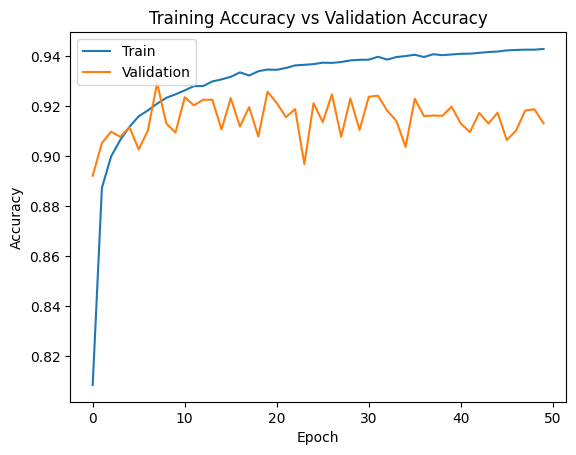

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

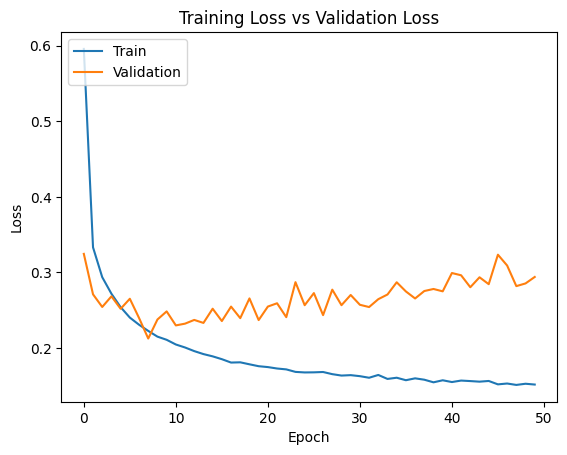

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Recognition and Post-Processing
1. The sort contours function is used to get the correct order of individual characters for correct output extraction. In this case for extracting a single word, a left to right sorting of individual characters is needed.
2. The get letters function fetches the list of letters and get word function gets the individual word.

In [30]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [31]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image

#plt.imshow(image)

In [32]:
def get_word(letter):
    word = "".join(letter)
    return word

1/1 [==============================] - 0s 53ms/step
BBNES


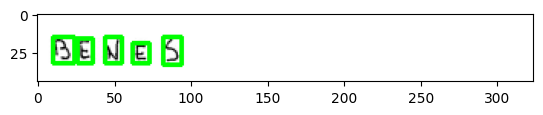

In [33]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00003.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 18ms/step
LIL0U


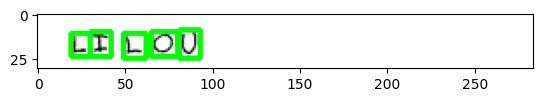

In [34]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00023.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 19ms/step
JAFFFLX


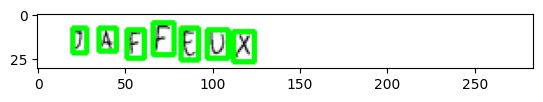

In [35]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00030.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 29ms/step
RUPP


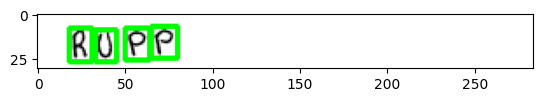

In [36]:
letter,image = get_letters("../input/handwriting-recognition/validation_v2/validation/VALIDATION_0005.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 20ms/step
VALENTJNF


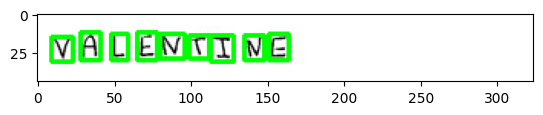

In [37]:
letter,image = get_letters("../input/handwriting-recognition/test_v2/test/TEST_0007.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

## Conclusion
This notebook is an illustration of how a character segmentation and classification approach can be used for offline handwritten text extraction. In order to improve the model, the model should be trained on the complete dataset, this notebook was trained on slightly less number of images due to session constraints. Also, for applying this method to a complete paragraph, following approach can be used, **line segmentation >> word segmentation >> character segmentation >> classification >> post-processing**.